In [64]:
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

from progressbar import ProgressBar
from scipy.io import loadmat
from matplotlib import pyplot as plt

%matplotlib notebook
from ipywidgets import *
plt.rcParams.update({'font.size': 16})

In [41]:
#Function to do moving average considering "window" number of observations from the past
def movingaverage(sequence, window):
    new_seq=np.zeros(len(sequence),)
    new_seq[0:window-1]=sequence[0:window-1]
    for j in range(window-1, len(sequence)):
        new_seq[j]=np.mean(sequence[j-window+1:j+1])
    return new_seq

# Function to seperate the time series into samples for next step prediction. "n_steps_in" is the lookback window
def splitsequence(sequence, n_steps_in, n_steps_out):
    X, Y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)

In [92]:
#Data preperation for training the deep learning model
bnet=np.arange(1,16)             #all the bearings
testb=[4,9,14]                  #test bearings
trainb=np.setdiff1d(bnet, testb) #train bearings
valb=[3,15]                       #validation
trainb=np.setdiff1d(trainb, valb)

n_steps_in, n_steps_out = 20, 1  #lookback window and one step prediction into future
n_features=1                     #considering only one VRMS 0.2x-sf/2

#bearing data can be mostly flat and if the training data is dominated by the healthy data - it affects the forecasting
#we therefore consider mostly degradation data
startdata=[0,0,40,0,0,400,0,100,0,100,2300, 2100, 300, 1380, 0]
b_id=trainb[0]
loaddata=loadmat('processeddata/VelFeaturesB_'+str(b_id)+'.mat')
FFv = loaddata['FFv']
raw_seq=movingaverage(FFv[:,51],3)  # the VRMS in y direction is at 52nd column
X, Y = splitsequence(raw_seq[startdata[b_id-1]:], n_steps_in, n_steps_out)
X = X.reshape((X.shape[0], X.shape[1], n_features))   #samples of length n_steps_in
Y = Y.reshape((Y.shape[0], Y.shape[1], n_features))   #next step prediction value

allX=X    
allY=Y
for i in range(1,len(trainb)):
    b_id=trainb[i]
    loaddata=loadmat('processeddata/VelFeaturesB_'+str(b_id)+'.mat')
    FFv = loaddata['FFv']
    raw_seq=movingaverage(FFv[:,51],3)  # the VRMS in y direction
    X, Y = splitsequence(raw_seq[startdata[b_id-1]:], n_steps_in, n_steps_out)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    Y = Y.reshape((Y.shape[0], Y.shape[1], n_features))
    allX=np.concatenate((allX,X),axis=0)  #combine for all bearings
    allY=np.concatenate((allY,Y),axis=0)  #combine for all bearings

## Validation bearings: get allX_val and allY_val as validation data
b_id=valb[0]
loaddata=loadmat('processeddata/VelFeaturesB_'+str(b_id)+'.mat')
FFv = loaddata['FFv']
raw_seq=movingaverage(FFv[:,51],3)  # the VRMS in y direction
X, Y = splitsequence(raw_seq[startdata[b_id-1]:], n_steps_in, n_steps_out)
X = X.reshape((X.shape[0], X.shape[1], n_features))
Y = Y.reshape((Y.shape[0], Y.shape[1], n_features))

allX_val=X
allY_val=Y
for i in range(1,len(valb)):
    b_id=valb[i]
    loaddata=loadmat('processeddata/VelFeaturesB_'+str(b_id)+'.mat')
    FFv = loaddata['FFv']
    raw_seq=movingaverage(FFv[:,51],3)  # the VRMS in y direction
    X, Y = splitsequence(raw_seq[startdata[b_id-1]:], n_steps_in, n_steps_out)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    Y = Y.reshape((Y.shape[0], Y.shape[1], n_features))
    allX_val=np.concatenate((allX_val,X),axis=0)
    allY_val=np.concatenate((allY_val,Y),axis=0)
    
print("Training Samples: ", str(len(allX)), "Validation samples: ", str(len(allX_val)))

Training Samples:  1765 Validation samples:  192


In [96]:
# train the model with 10% dropout
model = Sequential()
model.add(LSTM(60, activation='tanh', input_shape=(n_steps_in, n_features), return_sequences=False, recurrent_dropout=0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
history=model.fit(allX, allY, epochs=100, verbose=1, shuffle=True, validation_data=(allX_val, allY_val))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60)                14880     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
56/56 [==============================] - 1s 13ms/step - loss: 0.0158 - val_loss: 0.0355
Epoch 2/100
56/56 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0326
Epoch 3/100
56/56 [==============================] - 1s 9ms/step - loss: 0.0044 - val_loss: 0.0276
Epoch 4/100
56/56 [==============================] - 1s 10ms/step - loss: 0.0042 - val_loss: 0.0254
Epoch 5/100
56/56 [==============================] - 1s 10ms/step - loss: 0.0038 - val_loss: 0.0253
Epoch 6/100
5

56/56 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0114
Epoch 77/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0087
Epoch 78/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0090
Epoch 79/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0105
Epoch 80/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0104
Epoch 81/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0083
Epoch 82/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0099
Epoch 83/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0096
Epoch 84/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0092
Epoch 85/100
56/56 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0116
Epo

<IPython.core.display.Javascript object>


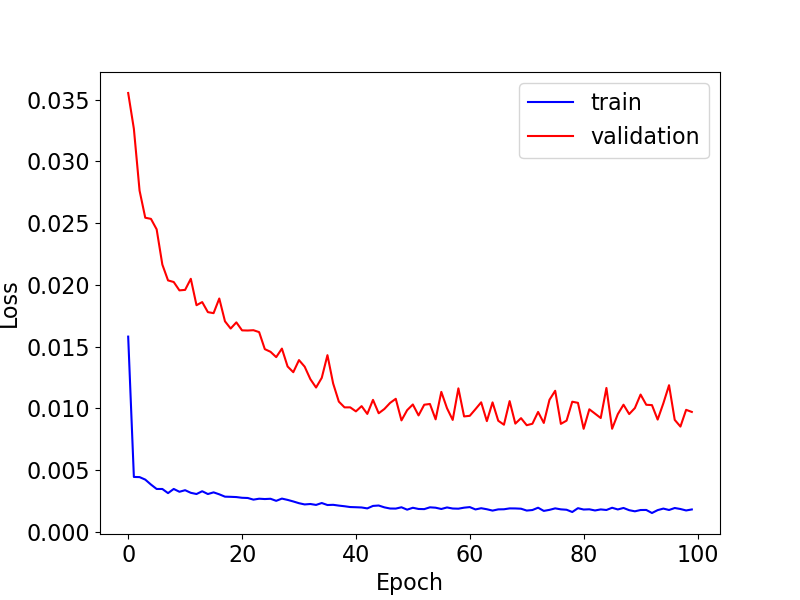

In [97]:
# plot the learning curves
fig=plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')

<IPython.core.display.Javascript object>


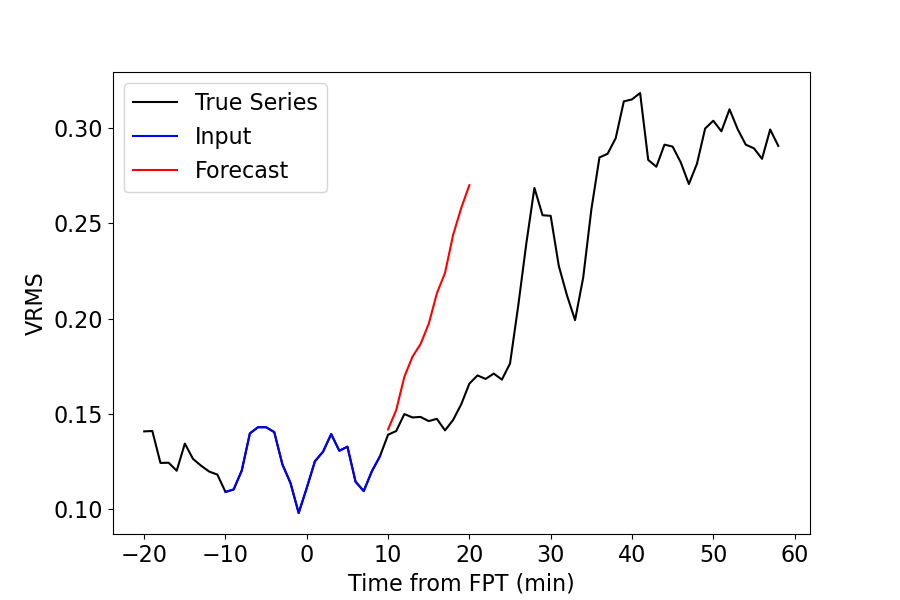

In [174]:
# Uncomment below to use a pre-trained model
# model=load_model('TraiLModel.h5')

## Now let us plot the forecast for a test bearing
cutoff=0.27

FPT=[79,55,60,106,26,456,50,316,32,123,2404,2450,343,1420,20]        #first prediction time
EOL=[121,96,150,122,41,489,154,398,35,199,2527,2495,352,1479,25]     #end of life

b_id=testb[2]
loaddata=loadmat('processeddata/VelFeaturesB_'+str(b_id)+'.mat')
FFv = loaddata['FFv']
raw_seq=movingaverage(FFv[FPT[b_id-1]-n_steps_in:EOL[b_id-1],51],3)  # series from FPT-n_steps_in
X, Y = splitsequence(raw_seq, n_steps_in, n_steps_out)

sampleno=10 # 10 mins from FPT
x_input=X[sampleno,:]
x_input=x_input.reshape(1,n_steps_in,n_features)
ynet=np.copy(x_input) #forecast - we will keep appending next step predictions here
mymax=max(x_input[0,:,0])
count=0
while mymax<cutoff:
    x_input=x_input.reshape(1,n_steps_in,n_features)
    ynext=model(x_input, training=True).numpy() #next step prediction
    ynext=ynext[0,0].reshape(1,1,1)
    ynet=np.concatenate((ynet,ynext),axis=1)  #concatenate next step prediction to create forecast
    mymax=max(ynet[0,:,0])
    x_input=ynet[0,-n_steps_in:,0]            #new input
    count=count+1
    if count>150:                             #break loop if forecast is not increasing
        break
rul=np.shape(ynet)[1]-n_steps_in

fig=plt.figure(figsize=(9,6))
plt.plot(np.arange(len(raw_seq))-n_steps_in,raw_seq,'k', label='True Series')
plt.plot(sampleno+np.arange(n_steps_in)-n_steps_in,ynet[0,0:n_steps_in,0], 'b', label='Input')
plt.plot(sampleno+np.arange(len(ynet[0])-n_steps_in),ynet[0,n_steps_in:,0],'r', label='Forecast')
plt.xlabel('Time from FPT (min)')
plt.ylabel('VRMS')
plt.legend()

In [175]:
# Write a function which provides RUL
def calculate_RUL(x_input, cutoff, n_steps_in):
    x_input=x_input.reshape(1,n_steps_in,1)
    ynet=np.copy(x_input) #forecast - we will keep appending next step predictions here
    mymax=max(x_input[0,:,0])
    count=0
    while mymax<cutoff:
        x_input=x_input.reshape(1,n_steps_in,n_features)
        ynext=model(x_input, training=True).numpy() #next step prediction
        ynext=ynext[0,0].reshape(1,1,1)
        ynet=np.concatenate((ynet,ynext),axis=1)    #concatenate next step prediction to create forecast
        mymax=max(ynet[0,:,0])
        x_input=ynet[0,-n_steps_in:,0]              #new input
        count=count+1
        if count>150:                               #break loop if forecast is not increasing
            break
    rul=np.shape(ynet)[1]-n_steps_in
    return rul

In [176]:
FPT=[79,55,60,106,26,456,50,316,32,123,2404,2450,343,1420,20]        #first prediction time
EOL=[121,96,150,122,41,489,154,398,35,199,2527,2495,352,1459,25]     #end of life

b_id=testb[2]
loaddata=loadmat('processeddata/VelFeaturesB_'+str(b_id)+'.mat')
FFv = loaddata['FFv']
raw_seq=movingaverage(FFv[FPT[b_id-1]-n_steps_in:EOL[b_id-1],51],3)  # series from FPT-n_steps_in
X, Y = splitsequence(raw_seq, n_steps_in, n_steps_out)
nsamples=len(X)
predRUL=np.zeros(nsamples,)
actRUL=nsamples-np.arange(nsamples)-1
pbar=ProgressBar()
for sampleno in pbar(range(nsamples)):
    x_input=X[sampleno,:]
    predRUL[sampleno]=calculate_RUL(x_input, cutoff, n_steps_in)

100% (39 of 39) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


<IPython.core.display.Javascript object>


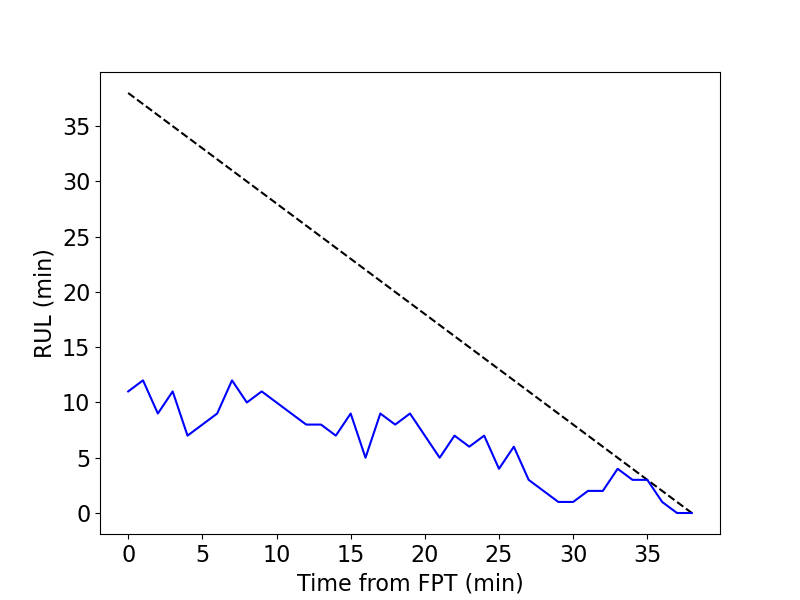

Text(0, 0.5, 'RUL (min)')

In [177]:
#Plot the remanining useful life
fig=plt.figure(figsize=(8,6))
plt.plot(actRUL, '--k', label='True RUL')
plt.plot(predRUL, 'b', label='Predicted RUL')
plt.xlabel('Time from FPT (min)')
plt.ylabel('RUL (min)')